## Install dependencies

In [ ]:
!pip install -U pythainlp openai-whisper transformers fairseq sacremoses matplotlib librosa scipy speechbrain torchaudio

In [2]:
!pip install speechbrain

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


## Import dependencies

In [5]:
import torch
import whisper
from pythainlp.translate import Translate

from transformers import VitsTokenizer, VitsModel, set_seed

from IPython.display import Audio

import matplotlib.pyplot as plt
import librosa

import scipy

from speechbrain.inference.speaker import EncoderClassifier
import torchaudio

## Load Model

In [6]:
model = whisper.load_model("medium")

/opt/homebrew/Caskroom/miniforge/base/envs/capstone/lib/python3.9/site-packages/whisper/__init__.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.loa

## Load audio file

In [7]:
original_audio_path = "./jp-01-money.mp3"

In [8]:
# load audio and pad/trim it to fit 30 seconds
audio = whisper.load_audio(original_audio_path)
audio = whisper.pad_or_trim(audio)

In [9]:
# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio).to(model.device)

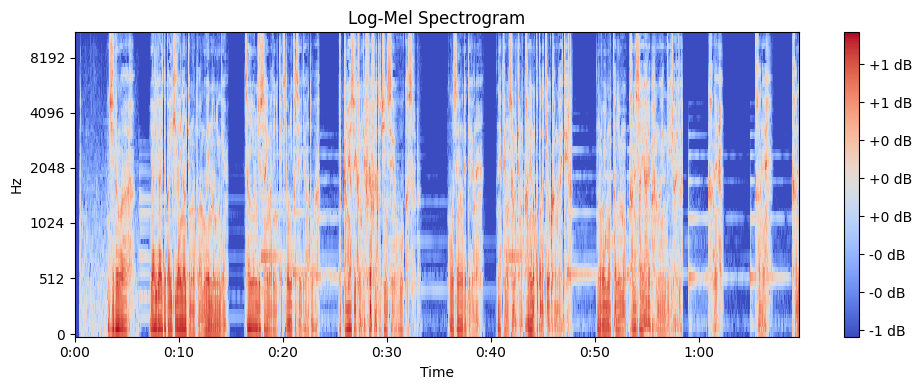

In [10]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel.cpu().numpy(), x_axis='time', y_axis='mel')
plt.title('Log-Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

## Detect language

In [11]:
# detect the spoken language
_, probs = model.detect_language(mel)
print(f"Detected language: {max(probs, key=probs.get)}")

Detected language: ja


## Transcript and Translate

In [12]:
# decode the audio and print
original_options = whisper.DecodingOptions()
translate_options = whisper.DecodingOptions(task="translate")

original_result = whisper.decode(model, mel, original_options)
translate_result = whisper.decode(model, mel, translate_options)

print("Original: " + original_result.text)
print("Translate: " + translate_result.text)

## Translate to Thai

In [ ]:
en2th = Translate('en', 'th')
th_text = en2th.translate(translate_result.text)

print("Translated Thai: " + th_text)

## Import VITS model

In [ ]:
vits_tokenizer = VitsTokenizer.from_pretrained("facebook/mms-tts-tha")
vits_model = VitsModel.from_pretrained("facebook/mms-tts-tha")

In [ ]:
# UROMAN tokenizer check
print(vits_tokenizer.is_uroman)

## Load speaker encoder

In [ ]:
# Load speaker encoder
speaker_encoder = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb")

# Extract speaker embedding from original audio
def extract_speaker_embedding(audio_path):
    waveform, sample_rate = torchaudio.load(audio_path)
    with torch.no_grad():
        embeddings = speaker_encoder.encode_batch(waveform)
    return embeddings.squeeze()

In [ ]:
speaker_embedding = extract_speaker_embedding(original_audio_path)

## Generate sound

In [ ]:
inputs = vits_tokenizer(text=th_text, return_tensors="pt")

set_seed(21)  # make deterministic

with torch.no_grad():
   outputs = vits_model(
               inputs["input_ids"],
               speaker_embeddings=speaker_embedding.unsqueeze(0)
            )

waveform = outputs.waveform[0]

## Preview

In [ ]:
Audio(waveform, rate=vits_model.config.sampling_rate)

## Save

In [ ]:
scipy.io.wavfile.write("output.wav", rate=vits_model.config.sampling_rate, data=waveform.detach().cpu().numpy())